# American options


## Contents
   - [Optimal early exercise boundary](#sec1)
   - [Binomial tree](#sec2)
   - [Longstaff - Schwartz](#sec3)
   - [Perpetual put](#sec4)
   
   
The American option problem is an optimal stopping problem formulated as follows:

$$ V(t,s) =  \sup_{\tau \in [t,T]} \mathbb{E}^{\mathbb{Q}}\biggl[ e^{-r(\tau-t)} \Phi(S_{\tau}) \bigg| S_t=s \biggr]$$

where $\Phi(\cdot)$ is the payoff, also called *intrinsic value*.    
This formula resembles the formula of a European option, except that in this case the option can be exercised at any time. But... at which time? The problem is to find the best exercise time $\tau$ that maximizes the expectation.

Notice that the time $\tau$ is a random variable! It can be different for different paths of the stock process.   
The solution of the problem provides a strategy, that at each time assesses if it is optimal to exercise the option or not, depending on the current value of the underlying stock.

It can be proved that the function $V(t,s)$ is the solution of the following PDE:

\begin{equation}
\max \biggl\{  \frac{\partial  V(t,s)}{\partial t}  
          + r\,s \frac{\partial V(t,s)}{\partial s}
          + \frac{1}{2} \sigma^2 s^2 \frac{\partial^2  V(t,s)}{\partial s^2} - r  V(t,s), \;  
          \Phi(s) - V(t,s) \biggr\}  = 0.
\end{equation}

$$ V(T,s) = \Phi(s) $$

The numerical algorithm for solving this PDE is almost identical to the algorithm proposed in the notebook **2.1** for the Black-Scholes PDE. 

Let us have a look at the differences between the implementation of the European and the American algorithm, in the class `BS_pricer`:

```python
if self.exercise=="European":        
    for i in range(Ntime-2,-1,-1):
        offset[0] = a * V[0,i]  
        offset[-1] = c * V[-1,i]
        V[1:-1,i] = spsolve( D, (V[1:-1,i+1] - offset) )
elif self.exercise=="American":
    for i in range(Ntime-2,-1,-1):
        offset[0] = a * V[0,i]
        offset[-1] = c * V[-1,i]
        V[1:-1,i] = np.maximum( spsolve( D, (V[1:-1,i+1] - offset) ), Payoff[1:-1])
```

The European and the American algorithms just differ in one line!!    

I don't consider dividends in the notebook. In absence of dividends the American call has the same value of the European call. For this reason, I'm going to consider only the pricing problem of a put option

$$ \Phi(S_{\tau}) = ( K - S_{\tau} )^+ $$


In [1]:
from FMNM.BS_pricer import BS_pricer
from FMNM.Parameters import Option_param
from FMNM.Processes import Diffusion_process
from FMNM.cython.solvers import PSOR

import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import display
import sympy

sympy.init_printing()


def display_matrix(m):
    display(sympy.Matrix(m))

In [2]:
# Creates the object with the parameters of the option
opt_param = Option_param(S0=100, K=100, T=1, exercise="American", payoff="put")
# Creates the object with the parameters of the process
diff_param = Diffusion_process(r=0.1, sig=0.2)
# Creates the pricer object
BS = BS_pricer(opt_param, diff_param)

The class `BS_pricer` implements two algorithms to price American options:
- the Longstaff-Schwartz Method (see section [below](#sec2))
- the PDE method

In [3]:
BS.LSM(N=10000, paths=10000, order=2)  # Longstaff Schwartz Method

In [4]:
N_space = 8000
N_time = 5000
BS.PDE_price((N_space, N_time))

#### Plot American put curve

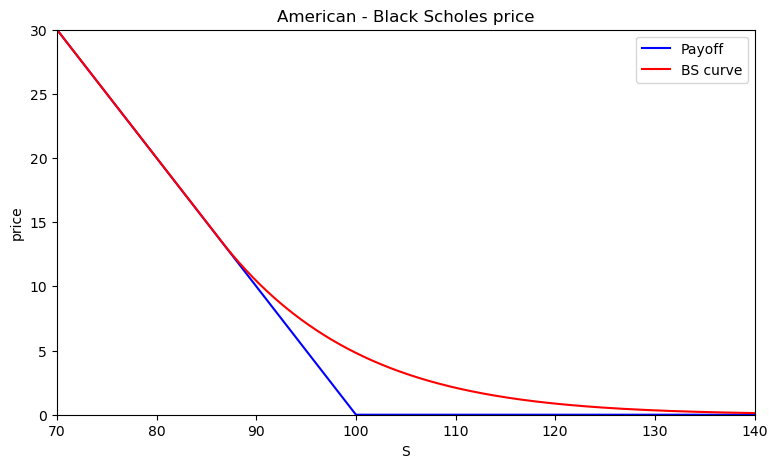

In [5]:
fig = plt.figure(figsize=(9, 5))
BS.plot([70, 140, 0, 30])

<a id='sec1'></a>
## Optimal early exercise boundary

Let us define a free boundary by the value $0<S_f<K$ such that if the current stock price $S_t$ is smaller than $S_f$, then it is optimal to exercise the option, otherwise it is optimal to wait.

- $S_t < S_f \quad $ called  **stopping region**
- $S_t > S_f \quad $ called  **continuation region**

In the stopping region, the value of the option corresponds to its [intrinsic value](https://en.wikipedia.org/wiki/Intrinsic_value_(finance)) i.e. $V(t,S_t) = K-S_t$.     

In order to find $S_f$ we have to find the maximum value $s$ such that $V(t,s) - (K-s) = 0$:

In [6]:
payoff = BS.payoff_f(BS.S_vec).reshape(len(BS.S_vec), 1)  # Transform the payoff in a column vector
mesh = (BS.mesh - payoff)[1:-1, :-1]  # I remove the boundary terms
optimal_indeces = np.argmax(np.abs(mesh) > 1e-10, axis=0)  # I introduce the error 1e-10
T_vec = np.linspace(0, BS.T, N_time)  # Time vector

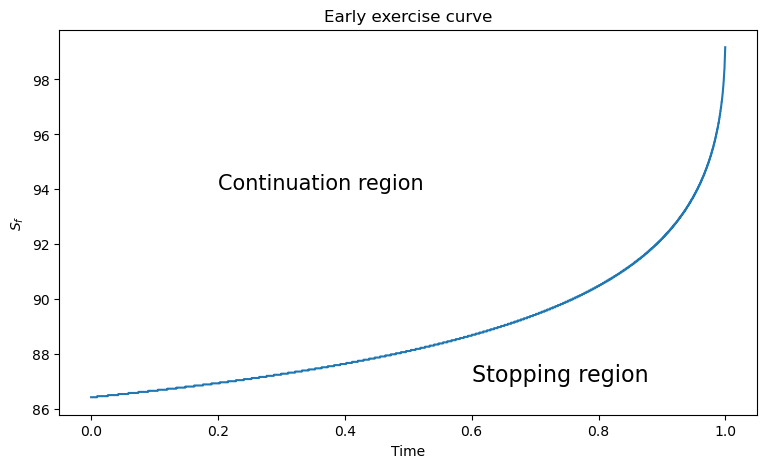

In [7]:
fig = plt.figure(figsize=(9, 5))
plt.plot(T_vec[:-1], BS.S_vec[optimal_indeces])
plt.text(0.2, 94, "Continuation region", fontsize=15)
plt.text(0.6, 87, "Stopping region", fontsize=16)
plt.xlabel("Time")
plt.ylabel("$S_f$")
plt.title("Early exercise curve")
plt.show()

<a id='sec2'></a>
## Binomial tree

One of the most used methods for pricing American options is the Binomial tree. 

We have already encountered the binomial tree in the notebook **1.1**. The following algorithm is almost a copy/paste from that notebook.     
There are just two additional lines:
- `S_T = S_T * u`. This an efficient method to retrive the price vector at each time steps.  
- `V = np.maximum( V, K-S_T )`. This line computes the maximum between the conditional expectation V and the intrisic value. 

In [8]:
S0 = 100.0  # spot stock price
K = 100.0  # strike
T = 1.0  # maturity
r = 0.1  # risk free rate
sig = 0.2  # diffusion coefficient or volatility

In [9]:
N = 25000  # number of periods or number of time steps
payoff = "put"  # payoff

dT = float(T) / N  # Delta t
u = np.exp(sig * np.sqrt(dT))  # up factor
d = 1.0 / u  # down factor

V = np.zeros(N + 1)  # initialize the price vector
S_T = np.array([(S0 * u**j * d ** (N - j)) for j in range(N + 1)])  # price S_T at time T

a = np.exp(r * dT)  # risk free compound return
p = (a - d) / (u - d)  # risk neutral up probability
q = 1.0 - p  # risk neutral down probability

if payoff == "call":
    V[:] = np.maximum(S_T - K, 0.0)
elif payoff == "put":
    V[:] = np.maximum(K - S_T, 0.0)

for i in range(N - 1, -1, -1):
    V[:-1] = np.exp(-r * dT) * (p * V[1:] + q * V[:-1])  # the price vector is overwritten at each step
    S_T = S_T * u  # it is a tricky way to obtain the price at the previous time step
    if payoff == "call":
        V = np.maximum(V, S_T - K)
    elif payoff == "put":
        V = np.maximum(V, K - S_T)

print("American BS Tree Price: ", V[0])

American BS Tree Price:  4.81624866310944


<a id='sec3'></a>
## Longstaff - Schwartz Method

This is a Monte Carlo algorithm proposed by Longstaff and Schwartz in the paper [1]:
[LS Method](https://people.math.ethz.ch/~hjfurrer/teaching/LongstaffSchwartzAmericanOptionsLeastSquareMonteCarlo.pdf)

The algorithm is not difficult to implement, but it can be difficult to understand.  I think this is the reason the authors started the paper with an example.    
Well. I think they had a good idea, and for this reason I want to reproduce their example here. 

The same code is copied in the class `BS_pricer` where the function `LSM` is implemented.

**If in the following code you feel that something is unclear, I suggest you to follow the steps (not in python) proposed in the original paper**.

In [10]:
N = 4  # number of time steps
r = 0.06  # interest rate
K = 1.1  # strike
T = 3  # Maturity

dt = T / (N - 1)  # time interval
df = np.exp(-r * dt)  # discount factor per time interval

In [11]:
S = np.array(
    [
        [1.00, 1.09, 1.08, 1.34],
        [1.00, 1.16, 1.26, 1.54],
        [1.00, 1.22, 1.07, 1.03],
        [1.00, 0.93, 0.97, 0.92],
        [1.00, 1.11, 1.56, 1.52],
        [1.00, 0.76, 0.77, 0.90],
        [1.00, 0.92, 0.84, 1.01],
        [1.00, 0.88, 1.22, 1.34],
    ]
)

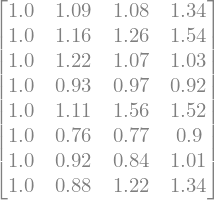

In [12]:
display_matrix(S)

In the previous cell we defined the stock matrix S.   
It has 8 rows that correspond to the number of paths.  
The 4 columns correspond to the 4 time steps, i.e. each row is a path with 4 time steps.

In [13]:
H = np.maximum(K - S, 0)  # intrinsic values for put option
V = np.zeros_like(H)  # value matrix
V[:, -1] = H[:, -1]

# Valuation by LS Method
for t in range(N - 2, 0, -1):
    good_paths = H[:, t] > 0  # paths where the intrinsic value is positive
    # the regression is performed only on these paths

    rg = np.polyfit(S[good_paths, t], V[good_paths, t + 1] * df, 2)  # polynomial regression
    C = np.polyval(rg, S[good_paths, t])  # evaluation of regression

    exercise = np.zeros(len(good_paths), dtype=bool)  # initialize
    exercise[good_paths] = H[good_paths, t] > C  # paths where it is optimal to exercise

    V[exercise, t] = H[exercise, t]  # set V equal to H where it is optimal to exercise
    V[exercise, t + 1 :] = 0  # set future cash flows, for that path, equal to zero
    discount_path = V[:, t] == 0  # paths where we didn't exercise
    V[discount_path, t] = V[discount_path, t + 1] * df  # set V[t] in continuation region

V0 = np.mean(V[:, 1]) * df  # discounted expectation of V[t=1]
print("Example price= ", V0)

Example price=  0.11443433004505696


The matrix `H = np.maximum(K - S, 0)`, is the matrix of intrinsic values:

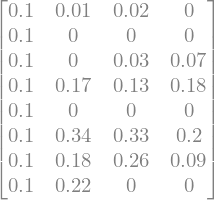

In [14]:
display_matrix(H.round(2))

The matrix V contains the cash flows.

**Important**    
To simplify the computations, the discounted cashflows are reported at every time steps. 

For instance:    
In the third row the final cashflow (0.07) is discounted at every time step, till t=1.    
In the paper, the authors just consider the cashflow (0.07) at time t=3 and the discount is performed at the end of the algorithm.

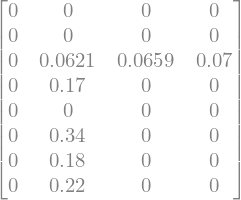

In [15]:
display_matrix(V.round(4))

<a id='sec4'></a>
## Perpetual put


An American option is called *perpetual* if it has no expiration date i.e. $T=\infty$:

$$ V(t,s) =  \sup_{\tau \in [t,\infty]} \mathbb{E}^{\mathbb{Q}}\biggl[ e^{-r(\tau-t)}\, ( K - S_{\tau} )^+ \, \bigg|\, S_t=s \biggr]. $$

By the time homogeneity of the problem we can set $t=0$ and obtain:

$$ V(s) =  \sup_{\tau \in [0,\infty]} \mathbb{E}^{\mathbb{Q}}\biggl[ e^{-r \tau}\, ( K - S_{\tau} )^+ \,\bigg|\, S_0=s \biggr]. $$

The PDE for the perpetual put option is:

$$
\max \biggl\{   
          r\,s \frac{ d V(s)}{d s}
          + \frac{1}{2} \sigma^2 s^2 \frac{d^2  V(s)}{d s^2} - r  V(s), \;  
          ( K - s )^+ - V(s) \biggr\}  = 0.
$$

In order to solve this obstacle problem we need to find a value $s_0 \in (0,K)$ such that:

$$ V(s) = ( K - s ) \quad \text{for} \quad s \in [0,s_0] \quad \text{ (stopping region)}$$

and 

$$ r\,s \frac{ d V(s)}{d s}
          + \frac{1}{2} \sigma^2 s^2 \frac{d^2  V(s)}{d s^2} - r  V(s) = 0 \quad \text{for} \quad s \in [s_0, \infty) \quad \text{ (continuation region)}$$
          
We can search for the solution of the linear second order ODE in the continuation region, by guessing a solution in the form $V(s) = s^n$.     
We then obtain a quadratic equation in $n$ that has two solutions $n_1=1$ and $n_2 = -\frac{2r}{\sigma^2}$.     
We can express 

$$V(s) = A s + B s^{-\frac{2r}{\sigma^2}} \quad \text{for} \quad s \in [s_0, \infty).$$  

Since $V(s) \to 0$ as $s\to \infty$, we must have $A=0$.    
We then require that *V(s)* is **continuous** and **differentiable** at $s_0$:

$$ B s_0^{-\frac{2r}{\sigma^2}} = K -s_0 \quad \text{and} \quad -\frac{2r}{\sigma^2} B s_0^{-\frac{2r}{\sigma^2}-1}  = -1$$

These equations are satisfied for:

$$ B = \frac{\sigma^2}{2r}\, s_0^{\frac{2r}{\sigma^2}+1} \quad \text{and} \quad s_0 = \frac{K}{\frac{\sigma^2}{2r}+1}. $$

It is also interesting to have a look at [2], where the author derives the formulas above using a probabilistic approach.

In [16]:
def perpetual_put(S, K, sigma, r):
    """analytical formula for perpetual put option"""
    s0 = K / (sigma**2 / (2 * r) + 1)
    B = sigma**2 / (2 * r) * s0 ** ((2 * r) / sigma**2 + 1)
    return np.where(S < s0, K - S, B * S ** (-2 * r / sigma**2))

In [17]:
S = np.linspace(60, 160, 1000)  # stock price
K = 100.0  # strike
r = 0.1  # risk free rate
sig = 0.2  # diffusion coefficient or volatility
s0 = K / (sig**2 / (2 * r) + 1)  # optimal excercise value

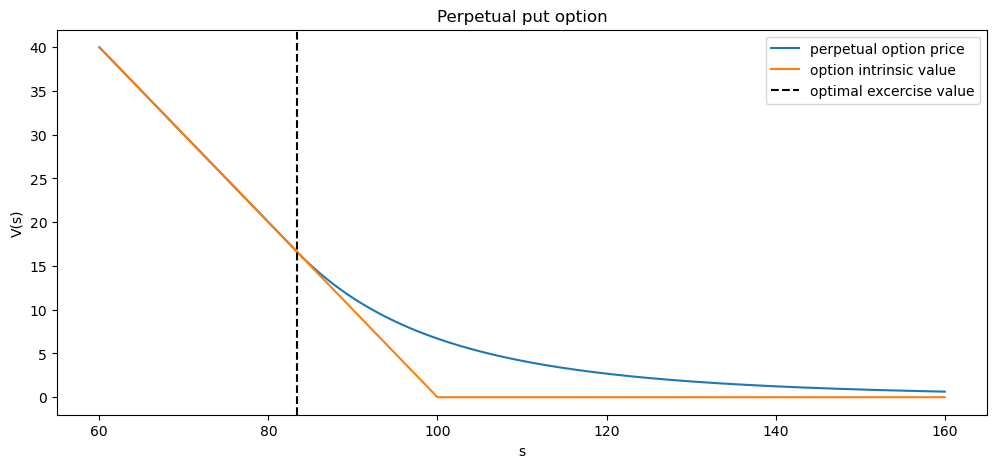

In [18]:
fig = plt.figure(figsize=(12, 5))
plt.plot(S, perpetual_put(S, K, sig, r), label="perpetual option price")
plt.plot(S, np.maximum(K - S, 0), label="option intrinsic value")
plt.axvline(x=s0, color="k", linestyle="--", label="optimal excercise value")
plt.xlabel("s")
plt.ylabel("V(s)")
plt.title("Perpetual put option")
plt.legend()
plt.show()

### Numerical computation of perpetual put

We can pass to the log-variable $x = \log s$ and obtain the simpler equation with constant coefficients:

$$ \max \biggl\{   
          (r - \frac{1}{2} \sigma^2) \, \frac{ d V(x)}{d x}
          + \frac{1}{2} \sigma^2 \frac{d^2  V(x)}{d x^2} - r  V(x), \;  
          ( K - e^x )^+ - V(x) \biggr\}  = 0. $$

equivalent to:

$$ \min \biggl\{   
          -(r - \frac{1}{2} \sigma^2) \, \frac{ d V(x)}{d x}
          - \frac{1}{2} \sigma^2 \frac{d^2  V(x)}{d x^2} + r  V(x), \;  
          V(x) - ( K - e^x )^+ \biggr\}  = 0. $$

This **variational inequality** can be reformulated as a **linear complementarity problem**:

$$ \biggl(   -(r - \frac{1}{2} \sigma^2) \, \frac{ d V(x)}{d x}
          - \frac{1}{2} \sigma^2 \frac{d^2  V(x)}{d x^2} + r  V(x),  
          \biggl)\, \cdot \biggl( V(x) - ( K - e^x )^+ \biggr)  = 0, $$
$$ -(r - \frac{1}{2} \sigma^2) \, \frac{ d V(x)}{d x}
          - \frac{1}{2} \sigma^2 \frac{d^2  V(x)}{d x^2} + r  V(x) \geq 0, 
          \quad \quad  V(x) - ( K - e^x )^+ \geq 0.
          $$          
          
At this poins, we can discretize the equations by finite difference using a central approximation for the first order derivative;

$$  -(r - \frac{1}{2} \sigma^2)  \frac{V_{i+1} -V_{i-1}}{ 2 \Delta x} 
    - \frac{1}{2} \sigma^2  \frac{V_{i+1} + V_{i-1} - 2 V_{i}}{\Delta x^2} + r  V_i  \geq 0 
 \quad \quad  V_i - ( K - e^{x_i} )^+ \geq 0. $$

That in matrix form becomes:

$$  A \, V - B \geq 0 \quad \quad V - C \geq 0 \quad \quad (A \, V - B)\cdot(V-C) = 0. $$

where as usual, $A$ is a tridiagonal matrix and $B$ is the vector containing the boundary values. $C$ is the payoff.

A description of numerical methods to solve the linear complementarity problem can be found in [3] or [4].     
Here it is important to choose a big value of `S_max` because the perpetual put price goes to zero asimptotically.     
The PSOR method is a slight modification of the SOR method introduced in the notebooks **A1** and **A2**. 

In [19]:
Nspace = 10000  # space steps
S_max = 10 * K  # very large in order to minimize the error due to asymptotic boundary condition
S_min = K / 3
x_max = np.log(S_max)
x_min = np.log(S_min)
x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)  # space discretization

In [20]:
sig2 = sig * sig
dxx = dx * dx

a = (r - 0.5 * sig2) / (2 * dx) - sig2 / (2 * dxx)  # -1 diagonal
b = sig2 / dxx + r  # main diagonal
c = -(r - 0.5 * sig2) / (2 * dx) - sig2 / (2 * dxx)  # +1 diagonal

In [21]:
C = np.maximum(K - np.exp(x), 0)  # payoff

B = np.zeros(Nspace)  # vector to be used for the boundary terms
B[0] = -a * (K - S_min)  # boundary condition
B[-1] = 0  # boundary condition

In [22]:
V = np.asarray(PSOR(a, b, c, B, C, w=1.999, eps=1e-12, N_max=1000000))

Convergence after 30017 iterations


#### Plot

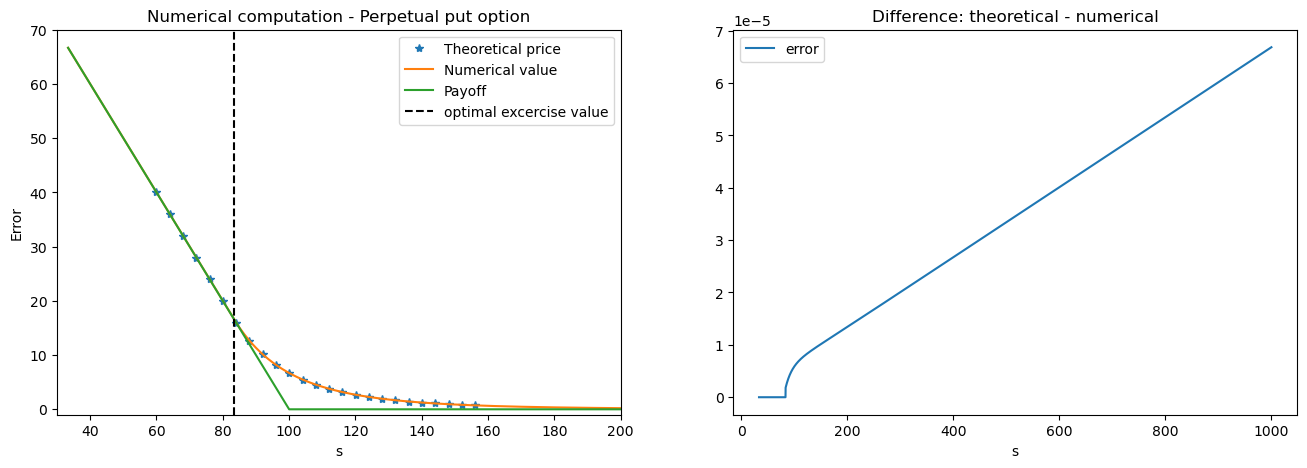

In [23]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(S[::40], perpetual_put(S[::40], K, sig, r), "*", label="Theoretical price")
ax1.plot(np.exp(x), V, label="Numerical value")
ax1.plot(np.exp(x), C, label="Payoff")
ax1.axvline(x=s0, color="k", linestyle="--", label="optimal excercise value")
ax1.axis([30, 200, -1, 70])
ax1.set_title("Numerical computation - Perpetual put option")
ax1.set_xlabel("s")
ax1.set_ylabel("V(s)")
ax1.legend()
ax2.plot(np.exp(x), perpetual_put(np.exp(x), K, sig, r) - V, label="error")
ax2.set_title("Difference: theoretical - numerical")
ax2.set_xlabel("s")
ax1.set_ylabel("Error")
ax2.legend()
plt.show()

## References

[1] F. Longstaff, E. Schwartz (2001) *Valuing American Options by Simulation: A Simple Least-Squares Approach*, The Review of Financial Studies, vol 14-1, pag 113-147.   

[2] Steven Shreve, *Stochastic calculus for finance, volume 2*, (2004).

[3]  Daniel Sevcovic, Beata Stehlikova, Karol Mikula (2011). "Analytical and numerical methods for pricing financial derivatives". Nova Science Pub Inc; UK. 

[4] Wilmott Paul (1994). "Option pricing - Mathematical models and computation". Oxford Financial Press.